In [95]:
import warnings

warnings.filterwarnings("ignore")

# Non-sequential pipelining

## Forecast Scenario
* Electricity price forecast as a motivation use-case
* In the simplest scenario:
    * We use only historic data for forecasting


## Sequential Pipelines

* We can do this using a sequential pipeline.
* For electricity load forecasting a very simple pipeline may look as follows

<img src="../images/sequential-pipeline.png" alt="Sequential Pipelien" width="1000"/>


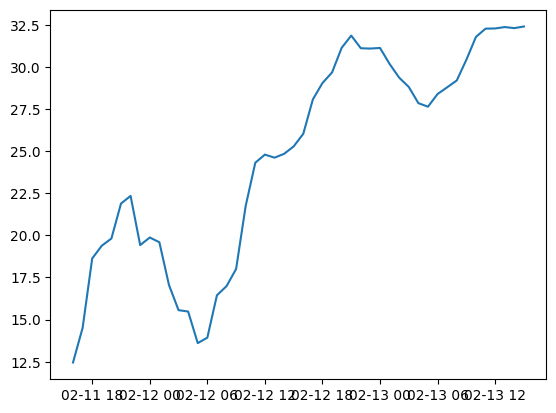

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import ARIMA
from sklearn.preprocessing import StandardScaler


# Load data
data = pd.read_csv("../data/getting_started_data.csv", parse_dates=["time"], index_col="time",)
data.index.freq = "H"
y = data["price"]
y_load = data["load_power_statistics"]
y_train = y.iloc[:1000]
y_train_load = y_load.iloc[:1000]
test_time = y.iloc[1000:1048].index
y_test_load = y_load.iloc[1000:1048]

# Build a simple pipeline
pipe = ForecastingPipeline(steps=[
    ("standardscaler", TabularToSeriesAdaptor(StandardScaler())),
    ("forecaster", ARIMA(order=(24, 0, 0))),
])
# Train the pipeline
pipe.fit(y_train,)

# Predict one Step
fh = ForecastingHorizon(test_time, is_relative=False)
y_pred = pipe.predict(fh=fh)
plt.plot(y_pred)



### However
* additional benefical features for electrical demand forecasting exists
    * calendar features, which need to be extracted or
    * future electrical demand
* Requires additional pipelines, which's sticked are put together
    * One price forecasting pipeline
    * One Feature extraction pipeline
    * One electrical load forecasting pipeline


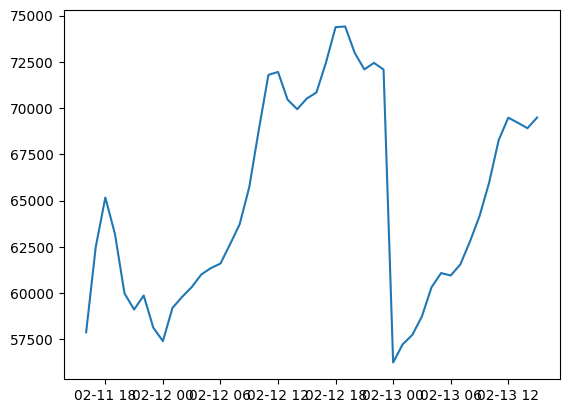

In [102]:
from sktime.transformations.series.date import DateTimeFeatures

# Construct a load forecasting pipeline
load_pipe = ForecastingPipeline(steps=[
    ("standardscaler", TabularToSeriesAdaptor(StandardScaler())),
    ("forecaster", ARIMA((24, 0, 0))),
])

# Construct a price forecasting pipeline
price_pipe = ForecastingPipeline(steps=[
    ("standardscaler", TabularToSeriesAdaptor(StandardScaler())),
    ("forecaster", ARIMA((24, 0, 0))),
])
dt_features_train = DateTimeFeatures(ts_freq="H", manual_selection=["hour_of_day", "day_of_week"]).fit_transform(y_train_load)[["hour_of_day", "day_of_week"]]

# Train all pipelines
load_pipe.fit(y_train_load, dt_features_train)

dt_features_test = DateTimeFeatures(ts_freq="H", manual_selection=["hour_of_day", "day_of_week"]).fit_transform(y_test_load)[["hour_of_day", "day_of_week"]]

predicted_load_train = load_pipe.predict(fh=y_train_load.index, X=dt_features_train)
predicted_load_test = load_pipe.predict(fh=y_test_load.index, X=dt_features_test)
plt.plot(predicted_load_test)

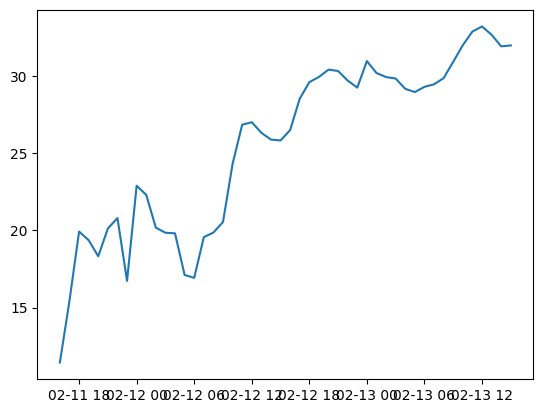

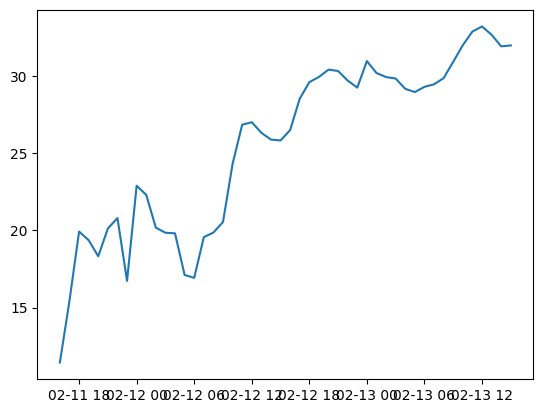

In [104]:
X = dt_features_train

X["load"] = predicted_load_train
price_pipe.fit(y_train, X=X)

# Execute all to predict the future
X = dt_features_test
X["load"] = predicted_load_test
predicted_price = price_pipe.predict(fh=fh, X=X)

plt.plot(predicted_price)

### Alternnative: We use a Non-Sequential Pipeline
* A non-sequential pipelines allows the
    * Branching of data flows (calendar features are used by multiple different forecasts)
    * Merging of data flows (output of calendar feature extraction and load forecasting are used by the price forecast)

### Non-Sequential Eletrical Price Forecast Pipeline
<img src="../images/non-sequential-pipeline.png" alt="Non Sequential Pipelien" width="1000"/>


## Need for non-sequential pipelines
* List of further examplary use-cases on [GitHub](https://github.com/sktime/sktime/issues/3023)
    * Wind power generation forecast with hand-crafted feature extraction
    * Theta-Forecaster


## Outlook on Non-Sequential Pipelines

* Concept for realising non-sequential pipelines and prototype exists
* However it is still under development



In [99]:
# import numpy and pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Import Calendar feature Extraction from pyWATTS
from pywatts.modules import CalendarExtraction, CalendarFeature, SKLearnWrapper, Ensemble, FunctionModule
# Import sklearn Preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
# Import sktime models
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import ARIMA

# Import non-sequential pipeline from pyWATTS
from pywatts_pipeline.core.pipeline import Pipeline
from pywatts_pipeline.core.util.computation_mode import ComputationMode
from pywatts_pipeline.utils._xarray_time_series_utils import numpy_to_xarray

## Prototype

* Use-case: non-sequential proce forecasting
* Consist of multiple steps:

#### 1. Define pipeline structure

In [100]:
pipeline = Pipeline(path="../results")

# Extract dummy calendar features, using holidays from Germany
# NOTE: CalendarExtraction can't return multiple features.


# TODO change it that here "time" is possible!
pipeline.add_new_api(DateTimeFeatures(ts_freq="H", manual_selection=["hour_of_day", "day_of_week"]), "calendar", {"x": "time"})

pipeline.add_new_api(ARIMA(), "ARIMA",
                     {"y": "load_power_statistics",
                      "X": "calendar",
                      },
                     )
pipeline.add_new_api(AutoETS(), "ETS",
                     {"y": "load_power_statistics",}
                     )
pipeline.add_new_api(FunctionModule(lambda x: numpy_to_xarray(x.values.reshape((-1, 1)), x)),
                     "reshapedETS", {"x": "ETS"})
pipeline.add_new_api(FunctionModule(lambda x: numpy_to_xarray(x.values.reshape((-1, 1)), x)),
                     "reshapedARIMA", {"x": "ARIMA"})

pipeline.add_new_api(Ensemble(), "ensemble_forecast", {"x": "inverse_lr", "x2": "reshapedETS",
                                                       "x3": "reshapedARIMA",
                                                       "target": "load_power_statistics"},
                     )

# TODO richtiges verschieben mit ClockShift?

pipeline.add_new_api(SKLearnWrapper(name="LR Price", module=LinearRegression()), "LR Price",
                     {"x": "ensemble_forecast", "cal": "calendar", "target": "price_day_ahead"},
                     )


AttributeError: 'Pipeline' object has no attribute 'add_new_api'

## Load Data, Train, and Predict with the Pipeline

In [ ]:
data = pd.read_csv("data/getting_started_data.csv",
                   index_col="time",
                   parse_dates=["time"],
                   infer_datetime_format=True,
                   sep=",")
data = data.asfreq(pd.infer_freq(data.index))

train = data.iloc[:1000, :]

result = pipeline.train(data=train)

Execute and predict with the pipeline

In [ ]:
test = data.iloc[1000:1024]
test.drop("load_power_statistics", axis=1)

# TODO try to transform/predict instead of test!
result, _ = pipeline.test(data=test[: 24], fh=ForecastingHorizon(np.arange(1, 400), freq="1h"))
pipeline.get_step("ensemble_forecast", pipeline.assembled_steps).step.buffer["ensemble_forecast"].plot(label="Ensemble")
pipeline.get_step("inverse_lr", pipeline.assembled_steps).step.buffer["inverse_lr"].plot(label="LR")
pipeline.get_step("ETS", pipeline.assembled_steps).step.buffer["ETS"].plot(label="ETS")
pipeline.get_step("ARIMA", pipeline.assembled_steps).step.buffer["ARIMA"].plot(label="ARIMA")
plt.legend()
plt.show()
plt.close()
ax = result["target"].plot(label="LR Price Forecast")


# TODOs
* Use predict/transform instead of train
* Make things inside of the pipeline prettier
* Rename add_api_new
* Reduce the warnings, fix the corresponding issues
* Can we change the key target to price?
* Add images for:
    * Explaining non-sequential workflows
    * Showing the example pipeline we consider in the tutorial
* What is the problem with a gap between training and test data? Ensemble seems to make some problems...
* Improve the forecasting quality of all models!
